In [660]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import nltk
import emoji

from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.manifold import TSNE
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from nltk import word_tokenize
from bs4 import BeautifulSoup

from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.tag import pos_tag
from textblob import TextBlob


import eli5
import re, string
from string import punctuation

pd.set_option('display.max_colwidth', None)



plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
plt.rcParams['figure.figsize'] = (20, 10)
sns.set(style="whitegrid") # seteando tipo de grid en seaborn
pd.options.display.float_format = '{:20,.10f}'.format # suprimimos la notacion cientifica en los outputs

SMALL_SIZE = 8
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


from IPython.core.pylabtools import figsize
plt.rcParams['figure.figsize'] = (9, 6)


# Funciones Generales

In [731]:
CODE_LOCATION = {'al': 'alabama',
  'ak': 'alaska',
  'az': 'arizona',
  'ar': 'arkansas',
  'ca': 'california',
  'co': 'colorado',
  'ct': 'connecticut',
  'de': 'delaware',
  'dc': 'district of columbia',
  'fl': 'florida',
  'ga': 'georgia',
  'hi': 'hawaii',
  'id': 'idaho',
  'il': 'illinois',
  'in': 'indiana',
  'ia': 'iowa',
  'ks': 'kansas',
  'ky': 'kentucky',
  'la': 'louisiana',
  'me': 'maine',
  'md': 'maryland',
  'ma': 'massachusetts',
  'mi': 'michigan',
  'mn': 'minnesota',
  'ms': 'mississippi',
  'mo': 'missouri',
  'mt': 'montana',
  'ne': 'nebraska',
  'nv': 'nevada',
  'nh': 'new hampshire',
  'nj': 'new jersey',
  'nm': 'new mexico',
  'ny': 'new york',
  'nc': 'north carolina',
  'nd': 'north dakota',
  'oh': 'ohio',
  'ok': 'oklahoma',
  'or': 'oregon',
  'pa': 'pennsylvania',
  'ri': 'rhode island',
  'sc': 'south carolina',
  'sd': 'south dakota',
  'tn': 'tennessee',
  'tx': 'texas',
  'ut': 'utah',
  'vt': 'vermont',
  'va': 'virginia',
  'wa': 'washington',
  'wv': 'west virginia',
  'wi': 'wisconsin',
  'wy': 'wyoming',
  'as': 'american samoa',
  'gu': 'guam',
  'mh': 'marshall islands',
  'fm': 'micronesia',
  'mp': 'northern marianas',
  'pw': 'palau',
  'u.s.a': 'united states',
  'usa': 'united states',
  '304': 'west virginia',
  'd.c': 'district of columbia',
  'd.c.': 'district of columbia',                 
  'us': 'united states',
  'ny': 'new york',
  'nyc': 'new york city',
  'uk': 'united kingdom',
  'u.k': 'united kingdom',
  'u.k.': 'united kingdom',
  'bc': 'british columbia',
  'ab': 'alberta',
  'vi': 'virgin islands'}




#Imprimir metricas de las predicciones
def mostrar_metricas(y_test, y_pred):
    print('Reporte de clasificación: \n', classification_report(y_test, y_pred))
    print('Matriz de confusión: \n',confusion_matrix (y_test, y_pred))
    print('ROC: \n', metrics.roc_auc_score(y_test, y_pred))

    # Obtener y reformar la matriz de datos de 
    matrix = confusion_matrix (y_test, y_pred) 
    matrix = matrix.astype ('float') / matrix.sum (axis = 1) [:, np.newaxis] 

    # Build the plot
    plt.figure()
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={'size':10},cmap=plt.cm.Greens, linewidths=0.2)
    plt.xlabel('Predicción')
    plt.ylabel('Target')
    plt.title('Matriz de confusión')
    plt.show()
    
def grafico_pie(df, titulo, valores, etiquetas):
    fig = px.pie(df, values=valores, names=etiquetas)
    fig.update_layout(title_text=titulo,
                      template="plotly_white")
    fig.show()
    
def grafico_distr(df, columna, titulo, xtitulo, ytitulo):
    x1 = df.loc[df['target'] == 1][columna]
    x2 = df.loc[df['target'] == 0][columna]
    group_labels = ['Verdadero', 'Falso']
    colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']
    fig = ff.create_distplot([x1, x2], group_labels,colors=colors)
    fig.update_layout(title_text=titulo,
                      xaxis_title=xtitulo,
                      yaxis_title=ytitulo,
                      template="plotly_white")
    fig.show()
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


def resultados(pred, test_df):
    res_df=pd.DataFrame(test_df['id'])
    res_df['target']=pred
    res_df.to_csv('data/submission.csv', index=False)
    


stops = set(stopwords.words('english'))
#punctuation = list(string.punctuation)
punctuation = '!"$%&\()*+,-/:;<=>?[\\]“”^_`#{|}~’'


word_list = brown.words()
word_set = set(word_list)

def eliminar_char_espec(text):
    text = re.sub('[^-\'A-Za-z0-9]+', ' ', text)
    return text

def unir_texto(text):
    return ( ' '.join(text))

def eliminar_palabras_con(text, con):
    palabras = []
    for word in text.split():
        if con not in word:
            palabras.append(word)
    return unir_texto(palabras)


# Tipo de palabra
#https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

#Lematizar palabras
englishStemmer=SnowballStemmer("english")
lemmatizer = WordNetLemmatizer()

#Elimino stops words 
def eliminar_sw(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stops: 
            #pos = pos_tag([i.strip()])
            #word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(i.strip())
    return unir_texto(final_text)

def lematizar(text):
    final_text = []
    for i in text.split():
        pos = pos_tag([i.strip()])
        word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
        final_text.append(word)
    return unir_texto(final_text)

def minusculas(text):
    return text.lower()

def eliminar_nums(text):
    cadena = []
    for x in text:
         if x not in string.digits:
                cadena.append(x)
    return  ''.join(cadena)

def eliminar_punct(text):
    cadena = []
    for x in text:
         if x not in punctuation:
                cadena.append(x)
    return  ''.join(cadena)
        
def eliminar_espacios_multiples(text):
    text = re.sub(r"\s+"," ", text, flags = re.I)
    return text.strip()

def eliminar_palabras_con_numeros(text):
    return re.sub(r'\w*\d\w*', '', text).strip()

def eliminar_cortas(text):
    cadena = []
    for word in text.split():
        if len(word) > 1:
            cadena.append(word)
    return  ' '.join(cadena)

def convertir_location_code(text):
    cadena = []
    for word in text.split():
        if word in CODE_LOCATION:
            word = CODE_LOCATION[word]
        cadena.append(word)
    return  ' '.join(cadena)

def reemplazar_chars(text):
    text = text.replace('&amp;','and')
    text = text.replace('&gt;&gt;',' view ')
    text = text.replace('&gt;',' ')
    text = text.replace('&lt;',' ')
    text = text.replace('mph','miles per hour')
    text = text.replace('rcmp','royal canadian mounted police')
    text = text.replace('tch','trans canada highway')
    text = text.replace('mph','miles per hour')
    text = text.replace('lmfao','laughing my fucking ass off')
    text = text.replace('pkwy','park way')
    text = text.replace('hwy','high way')
    text = text.replace(' gov ',' government ')
    text = text.replace('govt','government')
    text = text.replace('gov\'t','government')

    
    text = text.replace('-',' ')
    text = text.replace('_',' ')
    text = text.replace('friend50','friend')
    text = text.replace('offr','officer')
    text = text.replace('pkk','kurdistan workers party')
    text = text.replace('v deo','video')
    text = text.replace('rly','really')
    text = text.replace('i\'m','i am')
    text = text.replace('don\'t','do not')
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('i\'ve','i have')
    text = text.replace('there\'s ','there is')
    text = text.replace('i\'ll ','i will')
    text = text.replace('doesn\'t','does not')
    text = text.replace('i\'d','i had')
    text = text.replace('didn\'t','did not')
    text = text.replace('we\'re','we are')
    text = text.replace('they\'re','they are')
    text = text.replace('isn\'t','is not')
    text = text.replace('what\'s','what is')
    text = text.replace('let\'s','let us')
    text = text.replace('ain\'t','am not')
    text = text.replace('that\'s','that is')
    text = text.replace('won\'t','will not')
    text = text.replace('wasn\'t','was not')
    text = text.replace('hasn\'t','has not')
    text = text.replace('haven\'t','have not')
    text = text.replace('aren\'t','are not')
    text = text.replace('you\'ll','you will')
    
    text = text.replace('it\'s','it is')
    text = text.replace('you\'re','you are')
    text = text.replace('shouldn\'t','should not')
    text = text.replace('here\'s','here is it')
    text = text.replace('we\'ve','we have')
    text = text.replace('you\'ve','you have')
    text = text.replace('who\'s','who is')
    text = text.replace('y\'all','you all')
    text = text.replace('wouldn\'t','would not')
    text = text.replace('they\'ve','they have')
    text = text.replace('weren\'t','were not')
    text = text.replace('would\'ve','would have')
    text = text.replace('you\'d','you would')
    text = text.replace('they\'ll','they will')
    text = text.replace('we\'d','we would')
    text = text.replace('they\'d','they would')
    text = text.replace('we\'ll','we shall')
    text = text.replace('it\'ll','it will')
    text = text.replace('what\'s','what is')
    text = text.replace('can\'t','can not')
    text = text.replace('can t ','can not ')
    text = text.replace('he\'s','hi is')
    text = text.replace('hasn\'t','has not')


    
    text = text.replace(' u ',' you ')
    text = text.replace('1st','first')
    text = text.replace('2nd','second')
    text = text.replace('3rd','third')
    text = text.replace('4th','fourth')
    text = text.replace('5th','fourth')
    text = text.replace('6th','fourth')
    text = text.replace('7th','fourth')
    text = text.replace('lol ','')
    text = text.replace(' lol','')
    text = text.replace(' lol ','')
    text = text.replace(' rt','')
    text = text.replace(' rt ','')
    text = text.replace('u.s.','united states')
    text = text.replace('yd ','years ')
    text = text.replace('fvck','fuck')
    text = text.replace('p.m.','post meridiem')
    text = text.replace(' pm ','post meridiem')
    text = text.replace('a.m.','ante meridiem')
    text = text.replace(' a.m ','ante meridiem')
    text = text.replace(' rn ',' right now ')
    text = text.replace(' da ',' the ')
    return text
def eliminar_palabras_especiales(text):
    text = eliminar_palabras_con(text, 'http')
    text = eliminar_palabras_con(text, '@')
    text = eliminar_palabras_con(text, '#')
    text = eliminar_palabras_con(text, 'mmm')
    text = eliminar_palabras_con(text, 'mhm')
    text = eliminar_palabras_con(text, 'ww')
    text = eliminar_palabras_con(text, 'jsj')
    text = eliminar_palabras_con(text, 'haha')
    text = eliminar_palabras_con(text, 'hah')
    text = eliminar_palabras_con(text, 'ooh')

    return text

def formato_inicial(df):
    df['location'].fillna(value='', inplace=True)
    df['keyword'].fillna(value='', inplace=True)
    
    #Minúsculas
    df['keyword_clean'] = df.keyword.str.replace('%20', ' ')
    df['text_clean'] = df.text.str.replace('%20', ' ')
    df['location_clean'] = df.location.str.replace('%20', ' ')
    
    df['keyword'] = df.keyword_clean.str.lower()
    df['text_clean'] = df.text_clean.str.lower()
    df['location_clean'] = df.location_clean.str.lower()

    
    #Sobre location
    df['location_clean'] = df.location_clean.str.lower()
    df['location_clean'] = df.location_clean.apply(convertir_location_code)
    df['location_clean'] = df.location_clean.apply(eliminar_char_espec)
    df['location_clean'] = df.location_clean.apply(eliminar_punct)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_con_numeros)
    df['location_clean'] = df.location_clean.apply(eliminar_cortas)
    df['location_clean'] = df.location_clean.apply(eliminar_palabras_especiales)


    
    #Sobre text_clean
    df['text_clean'] = df.text_clean.str.replace('rt @', '')
    df['text_clean'] = df.text_clean.str.replace('rt ', '')
    df['text_clean'] = df.text_clean.str.replace('rt:', '')   
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_especiales)
    df['text_clean'] = df.text_clean.apply(eliminar_palabras_con_numeros)
    df['text_clean'] = df.text_clean.apply(reemplazar_chars) #Va antes de eliminar puntuación
    df['text_clean'] = df.text_clean.apply(eliminar_char_espec)
    df['text_clean'] = df.text_clean.apply(eliminar_punct)
    df['text_clean'] = df.text_clean.str.replace('\'', '')
    #df['text_clean'] = df.text_clean.apply(eliminar_sw) 
    df['text_clean'] = df.text_clean.apply(lematizar) 
    #df['text_clean'] = df.text_clean + ' ' + df.location_clean
    df['text_clean'] = df.text_clean.apply(eliminar_espacios_multiples)
    df['text_clean'] = df.text_clean.apply(eliminar_cortas)

# Carga de datos

In [732]:
#train_df[train_df.target == 0]['location'].str.split(expand=True).stack().value_counts().to_csv('data/sample0.csv')
#train_df[train_df.target == 1]['location'].value_counts().to_csv('data/sample1.csv')
#cols= ['word_lenght']
#df = pd.get_dummies(train_df, columns=cols, drop_first=True)


train_df = pd.read_csv('data/train.csv', encoding='utf-8')
test_df = pd.read_csv('data/test.csv', encoding='utf-8')
formato_inicial(train_df)


In [663]:
train_df.head()

,id,keyword,location,text,target,keyword_clean,text_clean,location_clean
0,1,,,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,,our deeds are the reason of this may allah forgive us all,
1,4,,,Forest fire near La Ronge Sask. Canada,1,,forest fire near la ronge sask canada,
2,5,,,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,,all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected,
3,6,,,"13,000 people receive #wildfires evacuation orders in California",1,,people receive evacuation orders in california,
4,7,,,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,,just got sent this photo from ruby as smoke from pours into school,



# Gráficos

In [664]:
#grafico_distr(train_df, 'cant_palabras', 'Gráfico de distr. de cantidad de palabras en text',  'Cantidad', '')
#grafico_distr(train_df, 'cant_caracteres','Gráfico de dist. de cantidad de caracteres en text', 'Cantidad', '')
#grafico_distr(train_df, 'cant_stopwords_pct','Gráfico de distr. porcentual de stopwords en text', 'Porcentaje', '')
#grafico_distr(train_df, 'cant_mayus_pct', 'Gráfico de distr. porcentual de mayúsculas en text','Porcentaje', '')
#grafico_pie(train_df, 'Porcentaje de tweets que contienen link', 'ref_noticias', 'target')
#grafico_distr(train_df, 'cant_numeros', 'Gráfico de distr. porcentual de mayúsculas en text','Cantidad', '')



# LSTM

Tokens únicos:  10894
Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_159 (Embedding)    (None, 32, 100)           1089400   
_________________________________________________________________
spatial_dropout1d_93 (Spatia (None, 32, 100)           0         
_________________________________________________________________
lstm_99 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_228 (Dense)            (None, 2)                 130       
Total params: 1,131,770
Trainable params: 1,131,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2
161/161 [==============================] - 9s 56ms/step - loss: 0.5856 - accuracy: 0.6830 - val_loss: 0.5107 - val_accuracy: 0.7618
Epoch 2/2
60/60 [==============================] - 0s 7ms/step - loss: 

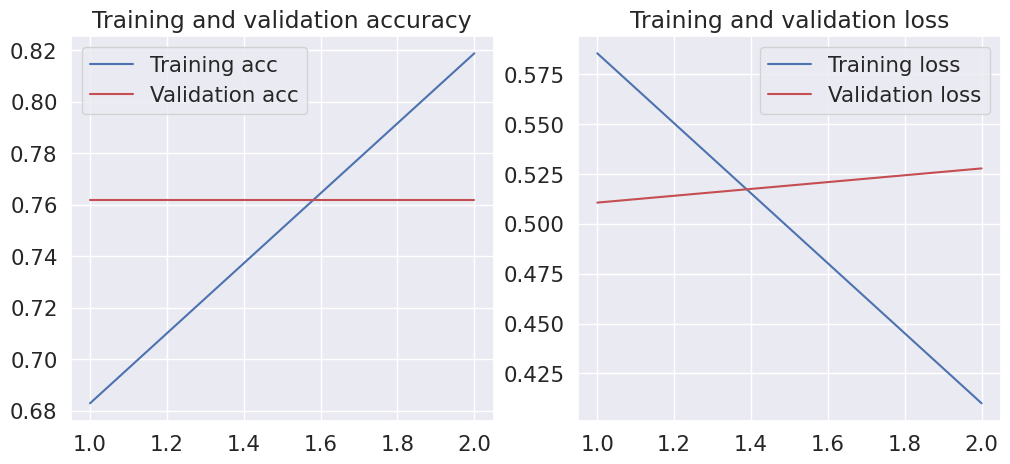

In [733]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NB_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100

X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X.values)

vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values
#y = y.values


# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)


model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.SpatialDropout1D(0.4))
model.add(layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


epochs = 2

batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# RED CONVOLUCIONAL 1D

Tokens únicos:  10894
Epoch 1/2
161/161 [==============================] - 4s 24ms/step - loss: 0.5892 - accuracy: 0.6851 - val_loss: 0.4935 - val_accuracy: 0.7583
Epoch 2/2
60/60 [==============================] - 0s 5ms/step - loss: 0.4456 - accuracy: 0.8046
Test set
  Loss: 0.446
  Accuracy: 0.805
Training Accuracy: 0.8567
Testing Accuracy:  0.8046


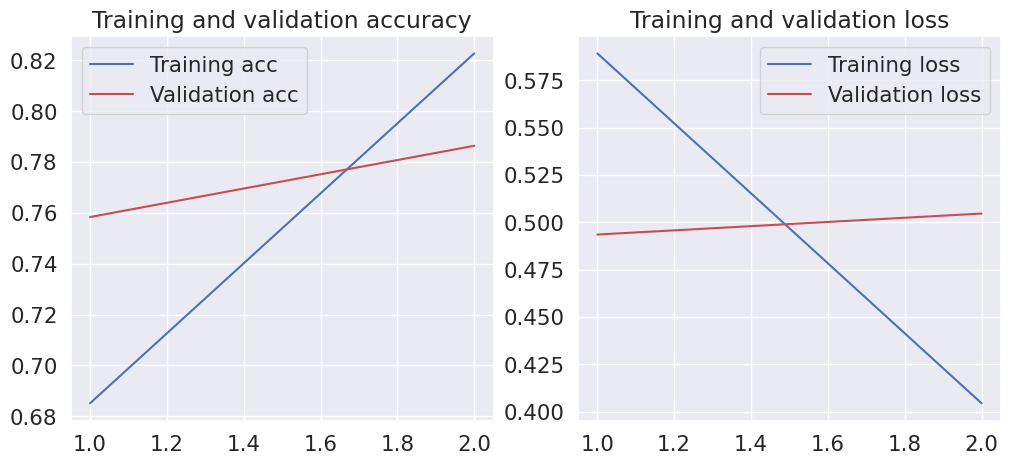

In [735]:
# Cantidad máxima de palabras en text_clean
MAX_SEQUENCE_LENGTH = train_df['text_clean'].str.split().str.len().max() + 1

#Maximo de palabras
MAX_NB_WORDS = 2000

# Matriz de salida
EMBEDDING_DIM = 100
X = train_df['text_clean']
y = train_df['target']


tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X.values)

vocab_size = len(tokenizer.word_index) + 1  # Más una columna para el index
print('Tokens únicos: ', vocab_size)

X = tokenizer.texts_to_sequences(X.values)

X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = pd.get_dummies(y).values

# Split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 0)

# Agrego unua red convolucional 1D
model = Sequential()
model.add(layers.Embedding(vocab_size, EMBEDDING_DIM ,input_length = X.shape[1]))
model.add(layers.Conv1D(200, 10, activation='sigmoid'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(2, activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


epochs = 2
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss',
                    patience=3, min_delta=0.0001)])

accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

# B. MLP Classifier

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.78      0.81      0.80      1107
           1       0.72      0.69      0.70       797

    accuracy                           0.76      1904
   macro avg       0.75      0.75      0.75      1904
weighted avg       0.76      0.76      0.76      1904

Matriz de confusión: 
 [[894 213]
 [248 549]]
ROC: 
 0.7482106000482841


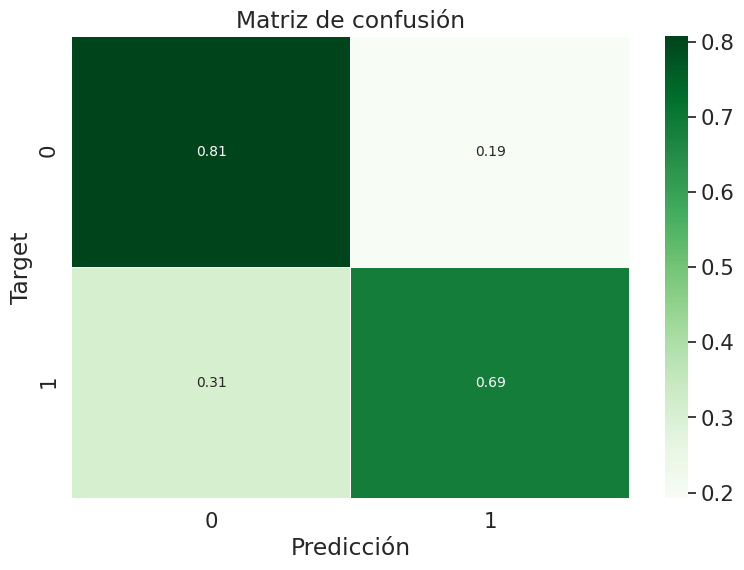

In [679]:
from sklearn.decomposition import PCA
from scipy.linalg import svd as scipy_svd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

MLP = MLPClassifier(activation='logistic', solver='adam',random_state=1)

MLP.fit(X_train, y_train)

#Predicciones
y_pred = MLP.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)



# C. Light GBM Classifier

Accu: 0.765 (0.013708)
Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.78      0.87      0.82      1107
           1       0.79      0.66      0.72       797

    accuracy                           0.78      1904
   macro avg       0.79      0.77      0.77      1904
weighted avg       0.79      0.78      0.78      1904

Matriz de confusión: 
 [[965 142]
 [268 529]]
ROC: 
 0.7677322026252467


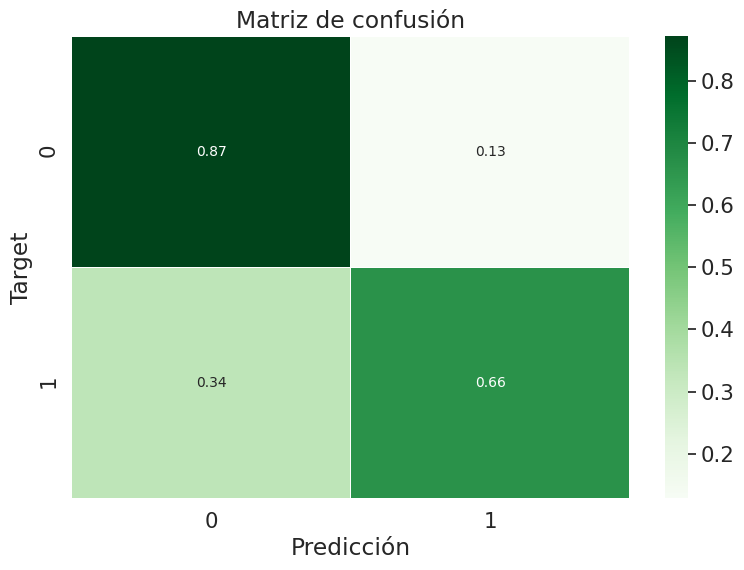

In [668]:
from lightgbm import LGBMClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


LGBM = LGBMClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(LGBM, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

print('Accu: %.3f (%.6f)' % (np.mean(n_scores), np.std(n_scores)))

#Fit
LGBM = LGBMClassifier()
LGBM.fit(X_train, y_train)

#Predicciones
y_pred = LGBM.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)


# 2. XGBoost - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.69      0.87      0.77      1107
           1       0.72      0.46      0.56       797

    accuracy                           0.70      1904
   macro avg       0.71      0.66      0.67      1904
weighted avg       0.70      0.70      0.68      1904

Matriz de confusión: 
 [[968 139]
 [434 363]]
ROC: 
 0.6649466891992215


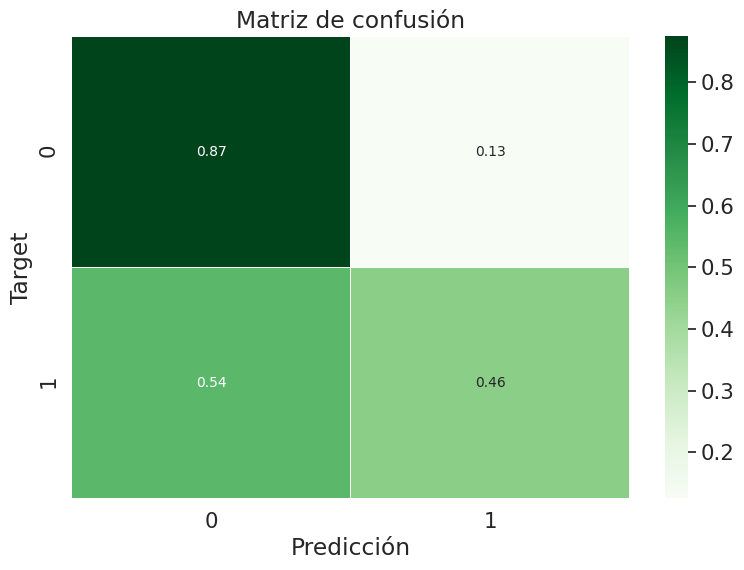

In [669]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import XGBClassifier

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


#Entrenamiento
alg = XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=5,
                    min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                    objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)

alg.fit(X_train, y_train, eval_metric='auc')

#Predicciones
y_pred = alg.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

# 3.  Random Forest Classifier - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.76      0.95      0.84      1107
           1       0.89      0.57      0.70       797

    accuracy                           0.79      1904
   macro avg       0.82      0.76      0.77      1904
weighted avg       0.81      0.79      0.78      1904

Matriz de confusión: 
 [[1049   58]
 [ 339  458]]
ROC: 
 0.761130549406707


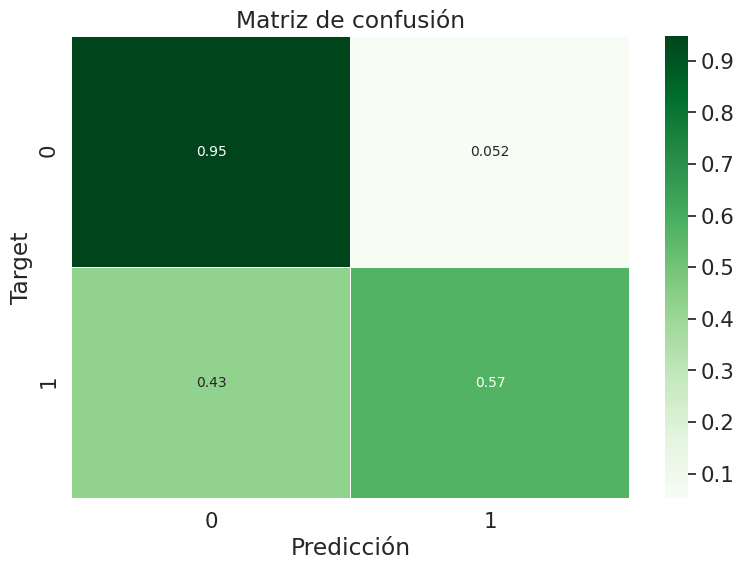

In [670]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# transform  to a normalized tf-idf representation 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
RFC = RandomForestClassifier(n_estimators=100, max_features='log2', n_jobs=-1)


RFC.fit(X_train, y_train)

#Predict
y_pred = RFC.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)

#Features importances
#features = np.array(X.columns)
importances = RFC.feature_importances_

'''

#Buscando parámetros 'buenos'
param_grid = { 
    'n_estimators': [100, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3,5,7,9,11, 13],
    'criterion' :['gini', 'entropy']
}

#Grid Search train
GSCV = GridSearchCV(estimator=RFC, param_grid=param_grid, cv= 5)
GSCV.fit(X_train, y_train)

# Best paramns
print(GSCV.best_params_)

'''
print('')

# 4. Regresión Logística - TEXT

In [688]:
from sklearn.model_selection import cross_val_score

X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Entrenamiento

LR = LogisticRegression(C=1.3, solver='liblinear', penalty='l2', n_jobs=-1)
LR.fit(X_train, y_train)


#Métricas
y_pred = LR.predict(X_test)
mostrar_metricas(y_test, y_pred)

#Feature estimator
eli5.show_weights(estimator=LR,feature_names= list(count_vect.get_feature_names()),top=(20, 20))

[0.79509632 0.77758319 0.76882662 0.8056042  0.80035026 0.78633975
 0.78809107 0.80735552 0.79334501 0.77894737]


# 5. KNN - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.76      0.90      0.83      1107
           1       0.82      0.61      0.70       797

    accuracy                           0.78      1904
   macro avg       0.79      0.76      0.77      1904
weighted avg       0.79      0.78      0.78      1904

Matriz de confusión: 
 [[1000  107]
 [ 308  489]]
ROC: 
 0.7584465911576723


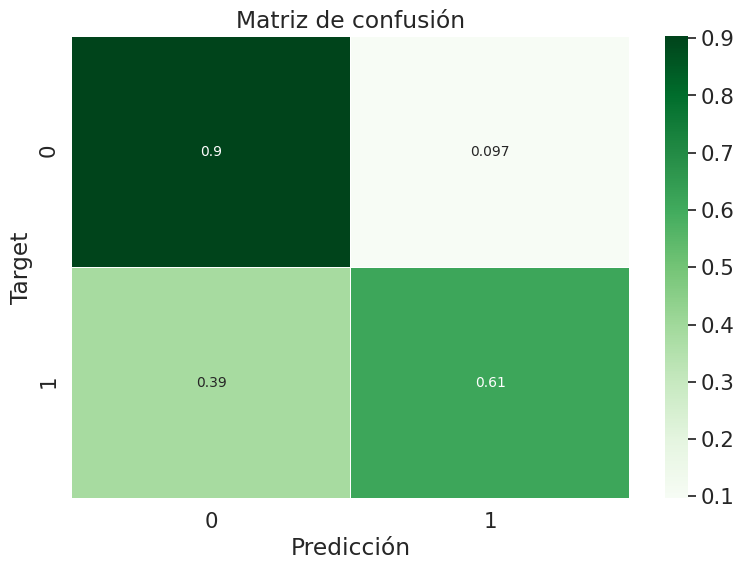

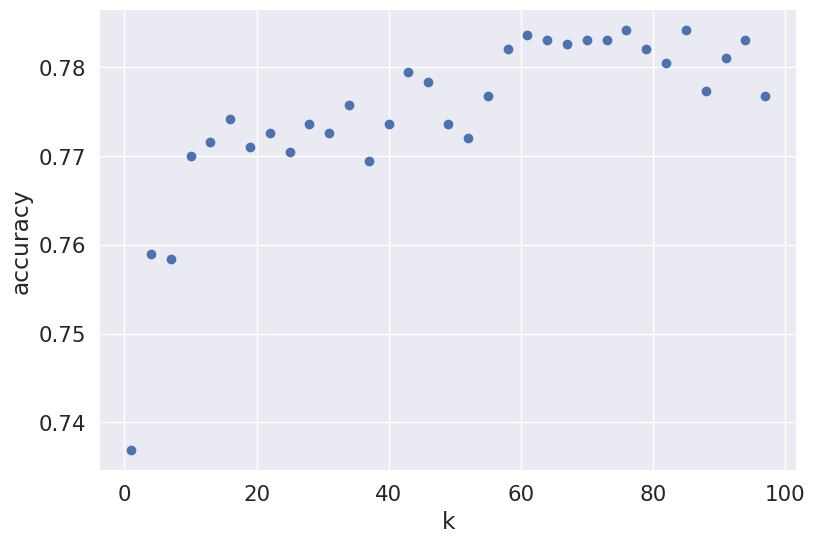

In [672]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

#Train
KNN = KNeighborsClassifier(n_neighbors = 79, metric='minkowski')
KNN.fit(X_train, y_train)

#Métricas
y_pred = KNN.predict(X_test)
mostrar_metricas(y_test, y_pred)


#Buscando un K 'bueno'
k_range = range(1,100, 3)
scores = []


for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k, metric='minkowski')
    KNN.fit(X_train, y_train)
    scores.append(KNN.score(X_test, y_test))
   # accuracy = metrics.accuracy_score(y_test, y_pred) #Accuracy

plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.show()



# 6. Multinomial NB - TEXT

Reporte de clasificación: 
               precision    recall  f1-score   support

           0       0.77      0.93      0.84      1107
           1       0.86      0.62      0.72       797

    accuracy                           0.80      1904
   macro avg       0.81      0.77      0.78      1904
weighted avg       0.81      0.80      0.79      1904

Matriz de confusión: 
 [[1024   83]
 [ 302  495]]
ROC: 
 0.7730508149916295


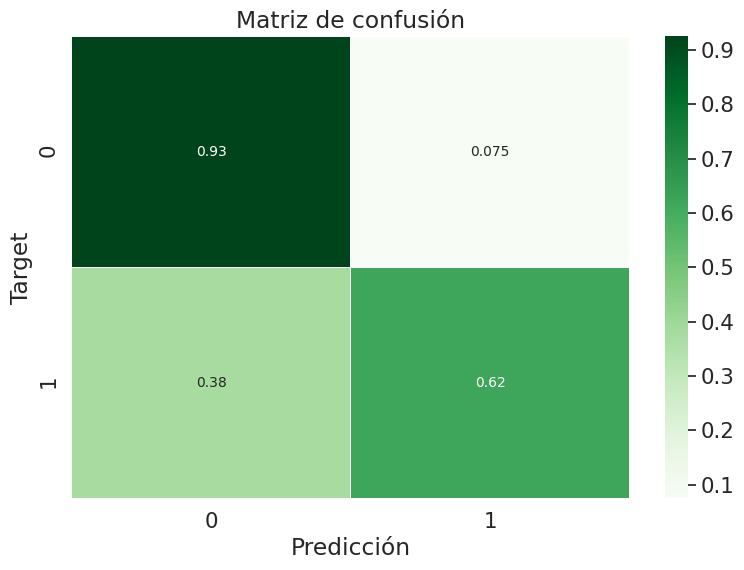

In [673]:
X = train_df['text_clean']
y = train_df['target']

#Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# Doc vs Term
count_vect = CountVectorizer()
X_train = count_vect.fit_transform(X_train)
X_test = count_vect.transform(X_test)

# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)


# Train
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Predict
y_pred = MNB.predict(X_test)

#Métricas
mostrar_metricas(y_test, y_pred)